In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-TAS

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
from shapely.geometry import box
import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① グリッドごとに SST を読み込む関数 (空間平均せずそのまま取得)
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print(f"[INFO] Reading: {fname}")
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸を ordinal に変換
        time_var = ds_nc.variables["time"][:]  # (T,)
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([datetime.datetime(d.year, d.month, d.day).toordinal() for d in cftime_objs])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドセルごとに marine.detect() を用いて指定日時の気候値との差 (anomaly) を計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    # 気候期間
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print(f"[INFO] Climatology data shape: {sst_clim.shape}")
    
    # 対象期間
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print(f"[INFO] Target data shape: {sst_target.shape}")
    
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"指定日時 {specified_date} が対象期間に含まれていません。")
    idx_target_date = idx_target_date[0]
    
    nlat = sst_target.shape[1]
    nlon = sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            try:
                ts_target_smooth = marine.runavg(
                    ts_target, w=runavg_window, allDates=t_target, isMultiYear=True
                )
            except Exception as e:
                print(f"[WARN] runavg error at cell ({i},{j}): {e}")
                ts_target_smooth = ts_target.copy()
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except Exception as e:
                print(f"[ERROR] detect() error at cell ({i},{j}): {e}")
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_value = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_value - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ プロット: アノマリーを描画後、塗りつぶした大陸を最前面に表示
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # カラースケールを 0.5℃ 刻み (より繊細なグラデーション)
    bounds = np.arange(-5, 5.5, 0.5)  # -5.0～5.0 を 0.5 刻み
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    
    # BoundaryNorm で bounds を指定
    norm = BoundaryNorm(bounds, n_colors)
    
    # world シェープファイル (Natural Earth) の読み込み
    # 例: "C:/Users/81909/MHW1/data/ne_10m_admin_0_countries.shp"
    shp_path = "C:/Users/81909/MHW1/data/ne_10m_admin_0_countries.shp"
    world = gpd.read_file(shp_path)
    
    # 対象領域で clip
    region = box(lons.min(), lats.min(), lons.max(), lats.max())
    world_clip = world[world.intersects(region)]
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    # 1) まず pcolormesh でアノマリーを描画 (zorder=1)
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        zorder=1
    )
    
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both')
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # 2) その後、大陸を塗りつぶし (facecolor) + 境界線 (edgecolor) で zorderを高く設定
    # facecolor で大陸内を塗りつぶし、edgecolor で境界線を太く
    world_clip.plot(
        ax=ax,
        facecolor="lightgray",   # 大陸塗りつぶし色
        edgecolor="green",       # 大陸境界線色
        linewidth=2,            # 境界線太さ
        zorder=10               # 大きな zorder で最前面
    )
    
    # 軸の範囲設定
    ax.set_xlim(lons.min(), lons.max())
    ax.set_ylim(lats.min(), lats.max())
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    lat_min, lat_max = -46, -39
    lon_min, lon_max = 147, 158.25
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    # 気候期間 / 対象期間
    clim_years = range(1983, 2013)
    target_years = range(2014, 2017)
    
    # 指定日時
    specified_date = date(2015, 12, 19)
    
    # runavg + detect() のパラメータ
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # プロット (アノマリー → 大陸塗りつぶし)
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0
0


c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


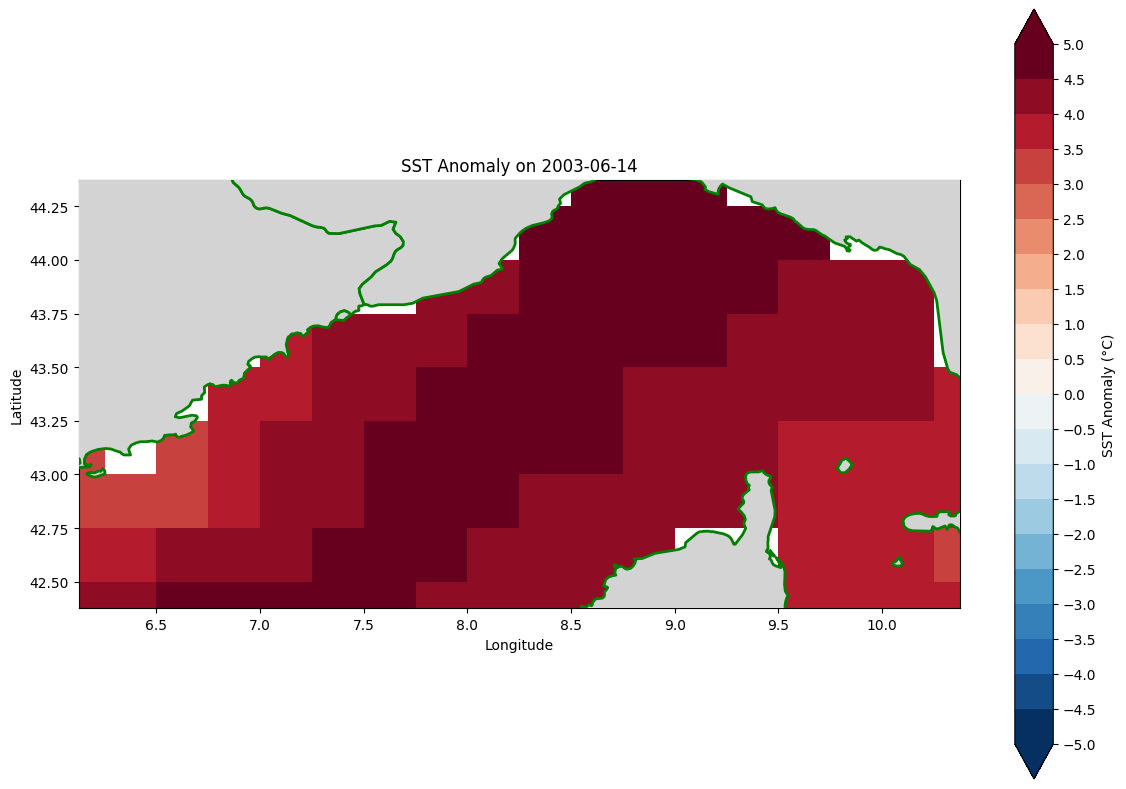

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-MED

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
from shapely.geometry import box
import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① グリッドごとに SST を読み込む関数 (空間平均せずそのまま取得)
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print(f"[INFO] Reading: {fname}")
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸を ordinal に変換
        time_var = ds_nc.variables["time"][:]  # (T,)
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([datetime.datetime(d.year, d.month, d.day).toordinal() for d in cftime_objs])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドセルごとに marine.detect() を用いて指定日時の気候値との差 (anomaly) を計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    # 気候期間
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print(f"[INFO] Climatology data shape: {sst_clim.shape}")
    
    # 対象期間
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print(f"[INFO] Target data shape: {sst_target.shape}")
    
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"指定日時 {specified_date} が対象期間に含まれていません。")
    idx_target_date = idx_target_date[0]
    
    nlat = sst_target.shape[1]
    nlon = sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            try:
                ts_target_smooth = marine.runavg(
                    ts_target, w=runavg_window, allDates=t_target, isMultiYear=True
                )
            except Exception as e:
                print(f"[WARN] runavg error at cell ({i},{j}): {e}")
                ts_target_smooth = ts_target.copy()
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except Exception as e:
                print(f"[ERROR] detect() error at cell ({i},{j}): {e}")
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_value = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_value - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ プロット: アノマリーを描画後、塗りつぶした大陸を最前面に表示
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # カラースケールを 0.5℃ 刻み (より繊細なグラデーション)
    bounds = np.arange(-5, 5.5, 0.5)  # -5.0～5.0 を 0.5 刻み
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    
    # BoundaryNorm で bounds を指定
    norm = BoundaryNorm(bounds, n_colors)
    
    # world シェープファイル (Natural Earth) の読み込み
    # 例: "C:/Users/81909/MHW1/data/ne_10m_admin_0_countries.shp"
    shp_path = "C:/Users/81909/MHW1/data/ne_10m_admin_0_countries.shp"
    world = gpd.read_file(shp_path)
    
    # 対象領域で clip
    region = box(lons.min(), lats.min(), lons.max(), lats.max())
    world_clip = world[world.intersects(region)]
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    # 1) まず pcolormesh でアノマリーを描画 (zorder=1)
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        zorder=1
    )
    
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both')
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # 2) その後、大陸を塗りつぶし (facecolor) + 境界線 (edgecolor) で zorderを高く設定
    # facecolor で大陸内を塗りつぶし、edgecolor で境界線を太く
    world_clip.plot(
        ax=ax,
        facecolor="lightgray",   # 大陸塗りつぶし色
        edgecolor="green",       # 大陸境界線色
        linewidth=2,            # 境界線太さ
        zorder=10               # 大きな zorder で最前面
    )
    
    # 軸の範囲設定
    ax.set_xlim(lons.min(), lons.max())
    ax.set_ylim(lats.min(), lats.max())
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    lat_min, lat_max = 42.25, 44.5
    lon_min, lon_max = 6, 10.5
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    # 気候期間 / 対象期間
    clim_years = range(1983, 2013)
    #target_years = range(2014, 2017)
    target_years = [2003]

    
    # 指定日時
    specified_date = date(2003, 6, 14)
    
    # runavg + detect() のパラメータ
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # プロット (アノマリー → 大陸塗りつぶし)
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


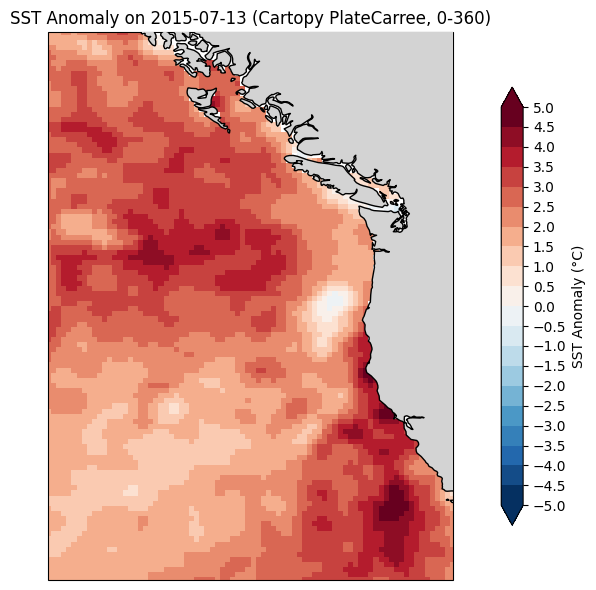

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    # こうすると 0～360 度系を自然に扱いつつ、日付変更線付近を内部処理してくれる
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景に海陸を表示 (塗りつぶしされた陸)
    # cartopy.feature.NaturalEarthFeature なども可
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で描画
    # transform=ccrs.PlateCarree() で lon, lat が 0～360 でも自動投影
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(Lon, Lat, anomaly_grid,
                       cmap=cmap, norm=norm,
                       shading='auto', edgecolors='none',
                       transform=ccrs.PlateCarree(),
                       zorder=2)
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    lat_min, lat_max = 30, 57
    lon_min, lon_max = 220, 240  # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2015]
    
    specified_date = date(2015, 7, 13)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0
0
0
0
0
0
0
0
0
0
0


c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


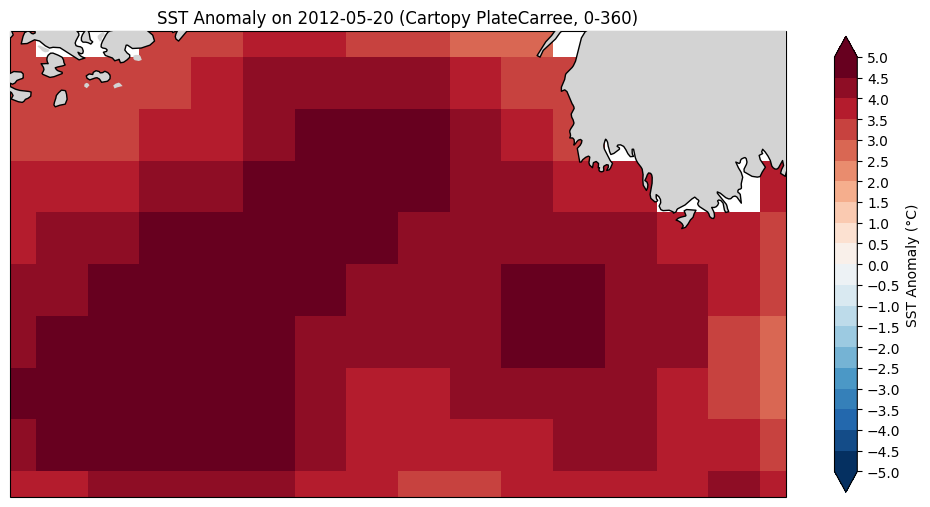

In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    # こうすると 0～360 度系を自然に扱いつつ、日付変更線付近を内部処理してくれる
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景に海陸を表示 (塗りつぶしされた陸)
    # cartopy.feature.NaturalEarthFeature なども可
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で描画
    # transform=ccrs.PlateCarree() で lon, lat が 0～360 でも自動投影
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(Lon, Lat, anomaly_grid,
                       cmap=cmap, norm=norm,
                       shading='auto', edgecolors='none',
                       transform=ccrs.PlateCarree(),
                       zorder=2)
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    lat_min, lat_max = 42, 44.5
    lon_min, lon_max = 291, 295  # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2012]
    
    specified_date = date(2012, 5, 20)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


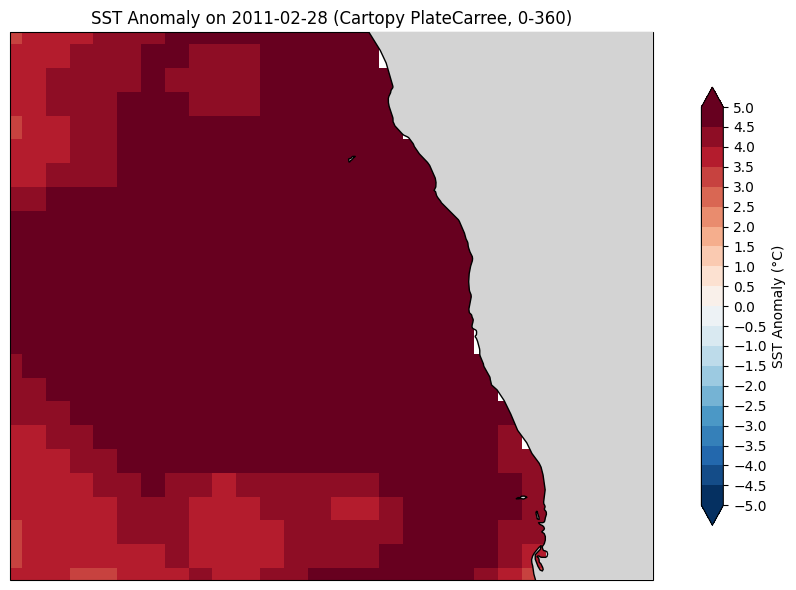

In [8]:
#!/usr/bin/env python wa
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    # こうすると 0～360 度系を自然に扱いつつ、日付変更線付近を内部処理してくれる
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景に海陸を表示 (塗りつぶしされた陸)
    # cartopy.feature.NaturalEarthFeature なども可
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で描画
    # transform=ccrs.PlateCarree() で lon, lat が 0～360 でも自動投影
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(Lon, Lat, anomaly_grid,
                       cmap=cmap, norm=norm,
                       shading='auto', edgecolors='none',
                       transform=ccrs.PlateCarree(),
                       zorder=2)
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    lat_min, lat_max = -33, -27
    lon_min, lon_max = 110, 117  # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2011]
    
    specified_date = date(2011, 2, 28)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


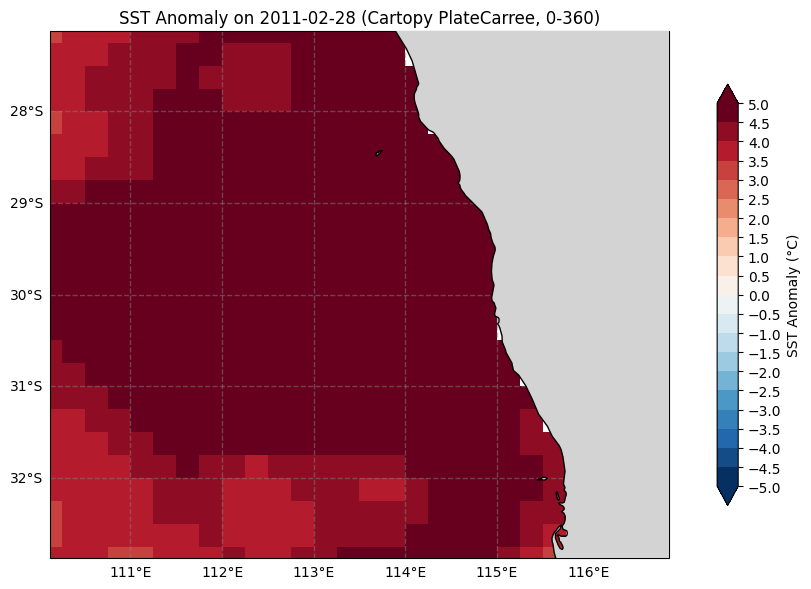

In [9]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker  # 経度・緯度のフォーマッタ
import cartopy.mpl.gridliner as cgrid

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画 + 経緯度目盛りを追加
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景: 塗りつぶし陸域 + 海岸線
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で SST anomaly
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        transform=ccrs.PlateCarree(),
        zorder=2
    )
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    # === グリッド線を追加し、ラベルを付与する ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,       # 軸にラベルを表示
        linewidth=1, color='gray', alpha=0.5, linestyle='--'
    )
    # Cartopy 0.18以降は gl.xlabels_top の代わりに gl.top_labels になる等、バージョン依存あり
    # 下記は状況に合わせて調整
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    # 軸ラベルのフォーマット
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    # 例: オーストラリア西部近辺
    lat_min, lat_max = -33, -27
    lon_min, lon_max = 110, 117   # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2011]
    
    specified_date = date(2011, 2, 28)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画 + 経緯度目盛り
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


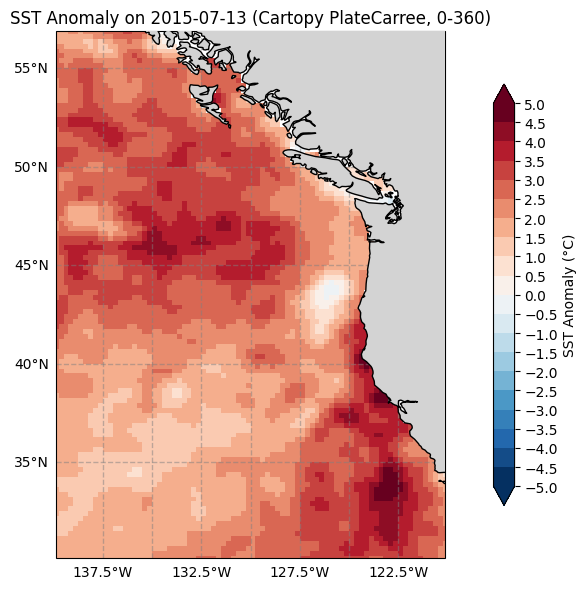

In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker  # 経度・緯度のフォーマッタ
import cartopy.mpl.gridliner as cgrid

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画 + 経緯度目盛りを追加
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景: 塗りつぶし陸域 + 海岸線
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で SST anomaly
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        transform=ccrs.PlateCarree(),
        zorder=2
    )
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    # === グリッド線を追加し、ラベルを付与する ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,       # 軸にラベルを表示
        linewidth=1, color='gray', alpha=0.5, linestyle='--'
    )
    # Cartopy 0.18以降は gl.xlabels_top の代わりに gl.top_labels になる等、バージョン依存あり
    # 下記は状況に合わせて調整
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    # 軸ラベルのフォーマット
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    # 例: オーストラリア西部近辺
    lat_min, lat_max = 30, 57
    lon_min, lon_max = 220, 240   # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2015]
    
    specified_date = date(2015, 7, 13)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画 + 経緯度目盛り
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0
0
0
0
0
0
0
0
0
0
0


c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


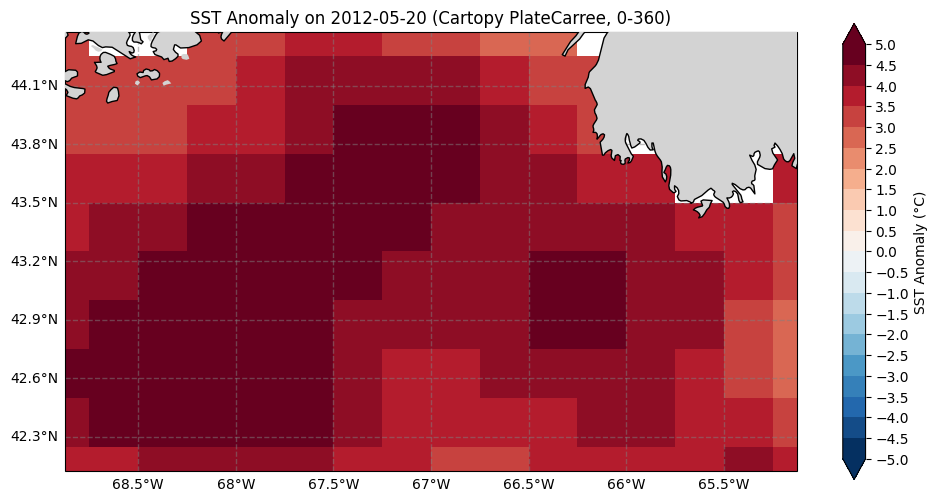

In [12]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker  # 経度・緯度のフォーマッタ
import cartopy.mpl.gridliner as cgrid

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画 + 経緯度目盛りを追加
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景: 塗りつぶし陸域 + 海岸線
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で SST anomaly
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        transform=ccrs.PlateCarree(),
        zorder=2
    )
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    # === グリッド線を追加し、ラベルを付与する ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,       # 軸にラベルを表示
        linewidth=1, color='gray', alpha=0.5, linestyle='--'
    )
    # Cartopy 0.18以降は gl.xlabels_top の代わりに gl.top_labels になる等、バージョン依存あり
    # 下記は状況に合わせて調整
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    # 軸ラベルのフォーマット
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    # 例: オーストラリア西部近辺
    lat_min, lat_max = 42, 44.5
    lon_min, lon_max = 291, 295   # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2012]
    
    specified_date = date(2012, 5, 20)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画 + 経緯度目盛り
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


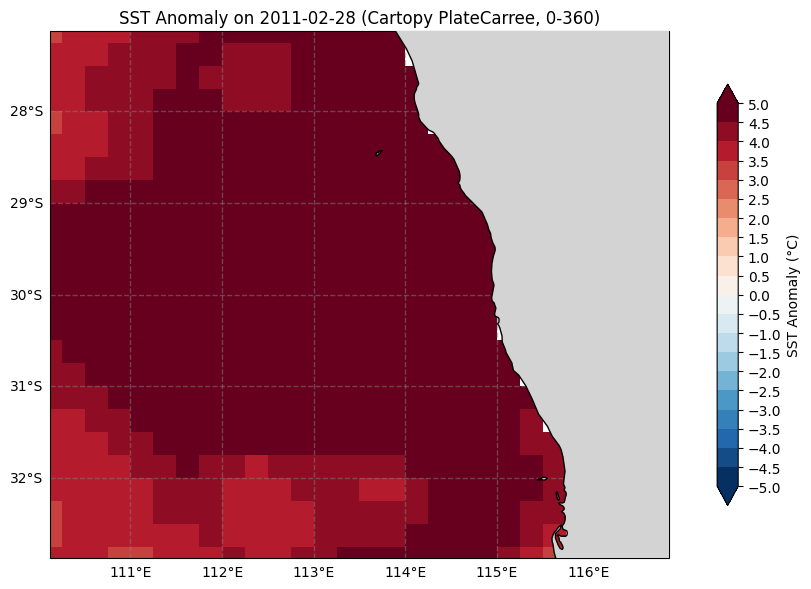

In [14]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker  # 経度・緯度のフォーマッタ
import cartopy.mpl.gridliner as cgrid

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画 + 経緯度目盛りを追加
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景: 塗りつぶし陸域 + 海岸線
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で SST anomaly
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        transform=ccrs.PlateCarree(),
        zorder=2
    )
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    # === グリッド線を追加し、ラベルを付与する ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,       # 軸にラベルを表示
        linewidth=1, color='gray', alpha=0.5, linestyle='--'
    )
    # Cartopy 0.18以降は gl.xlabels_top の代わりに gl.top_labels になる等、バージョン依存あり
    # 下記は状況に合わせて調整
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    # 軸ラベルのフォーマット
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    # 例: オーストラリア西部近辺
    lat_min, lat_max = -33, -27
    lon_min, lon_max = 110, 117   # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2011]
    
    specified_date = date(2011, 2, 28)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画 + 経緯度目盛り
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0


c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


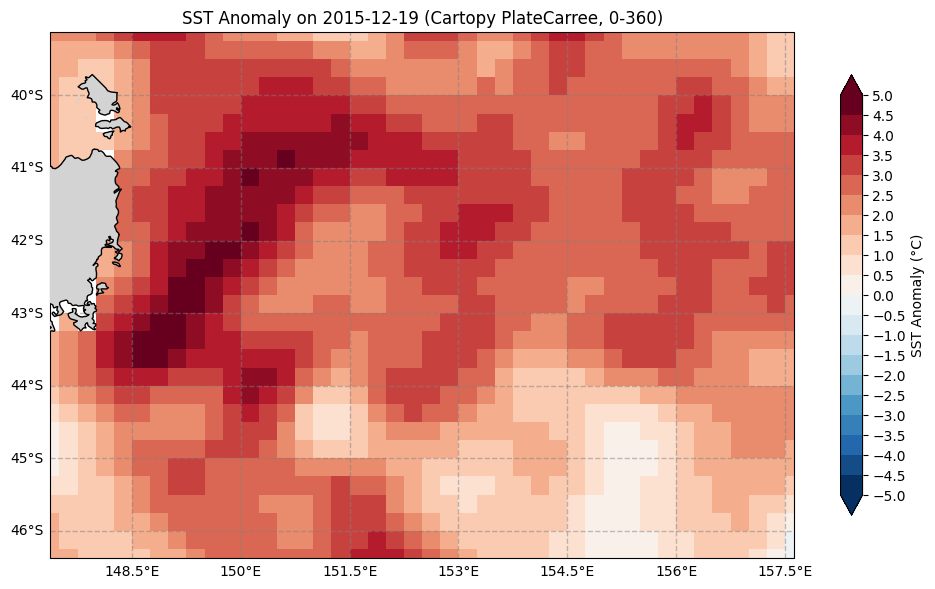

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker  # 経度・緯度のフォーマッタ
import cartopy.mpl.gridliner as cgrid

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画 + 経緯度目盛りを追加
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景: 塗りつぶし陸域 + 海岸線
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で SST anomaly
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        transform=ccrs.PlateCarree(),
        zorder=2
    )
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    # === グリッド線を追加し、ラベルを付与する ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,       # 軸にラベルを表示
        linewidth=1, color='gray', alpha=0.5, linestyle='--'
    )
    # Cartopy 0.18以降は gl.xlabels_top の代わりに gl.top_labels になる等、バージョン依存あり
    # 下記は状況に合わせて調整
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    # 軸ラベルのフォーマット
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    # 例: オーストラリア西部近辺
    lat_min, lat_max = -46.5, -39
    lon_min, lon_max = 147.25, 157.75   # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2015]
    
    specified_date = date(2015, 12, 19)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画 + 経緯度目盛り
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()


[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1983.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1984.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1985.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1986.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1987.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1988.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1989.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1990.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1991.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1992.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1993.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1994.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1995.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1996.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1997.nc
[INFO] Reading: C:/Users/81909/MHW1/DATA/sst.day.mean.1998.nc
[INFO] R

C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


0
0


c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar divide
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0


C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\81909\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\81909\MHW2\__pycache__\marine.py:257: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_onset'].append((mhw_relSeas[tt_peak] - mhw_relSeas[0]) / 1.)
c:\Users\81909\MHW2\__pycache__\marine.py:269: RuntimeWarning: invalid value encountered in scalar subtract
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) /


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


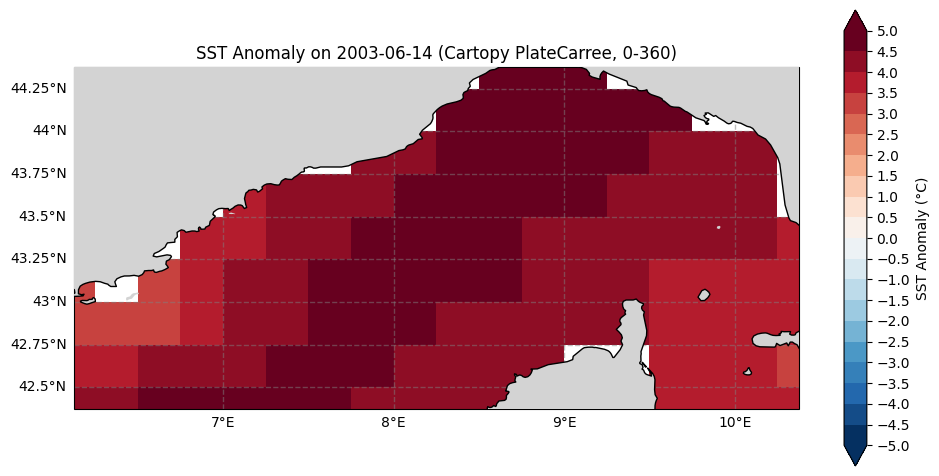

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import netCDF4
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker  # 経度・緯度のフォーマッタ
import cartopy.mpl.gridliner as cgrid

import marine  # marine.py が同ディレクトリまたは PYTHONPATH にある前提

# ---------------------------------------------------------------------------
# ① SST の読込（空間平均せずに3次元で取得）
# ---------------------------------------------------------------------------
def read_sst_ncfiles_grid(years, file_pattern, lat_min, lat_max, lon_min, lon_max):
    t_list = []
    sst_list = []
    for yr in years:
        fname = file_pattern.format(yr)
        print("[INFO] Reading:", fname)
        ds_nc = netCDF4.Dataset(fname, "r")
        
        # 時間軸
        time_var = ds_nc.variables["time"][:]
        time_units = ds_nc.variables["time"].units
        cftime_objs = netCDF4.num2date(time_var, time_units)
        t_ordinal = np.array([
            datetime.datetime(d.year, d.month, d.day).toordinal()
            for d in cftime_objs
        ])
        
        lat_all = ds_nc.variables["lat"][:]
        lon_all = ds_nc.variables["lon"][:]
        sst_3d = ds_nc.variables["sst"][:]
        ds_nc.close()
        
        # 指定領域 index
        lat_inds = np.where((lat_all >= lat_min) & (lat_all <= lat_max))[0]
        lon_inds = np.where((lon_all >= lon_min) & (lon_all <= lon_max))[0]
        
        sst_region = sst_3d[:, lat_inds, :][:, :, lon_inds]
        t_list.append(t_ordinal)
        sst_list.append(sst_region)
    
    t_all = np.concatenate(t_list)
    sst_all = np.concatenate(sst_list, axis=0)
    lats = lat_all[lat_inds]
    lons = lon_all[lon_inds]
    return t_all, sst_all, lats, lons

# ---------------------------------------------------------------------------
# ② 各グリッドに対し marine.detect() → anomaly 計算
# ---------------------------------------------------------------------------
def compute_anomaly_grid(clim_years, target_years, file_pattern,
                         lat_min, lat_max, lon_min, lon_max,
                         specified_date, runavg_window=3, pctile=90):
    t_clim, sst_clim, lats, lons = read_sst_ncfiles_grid(
        clim_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Climatology shape:", sst_clim.shape)
    
    t_target, sst_target, _, _ = read_sst_ncfiles_grid(
        target_years, file_pattern, lat_min, lat_max, lon_min, lon_max
    )
    print("[INFO] Target shape:", sst_target.shape)
    
    # 指定日時インデックス
    target_date_ord = specified_date.toordinal()
    idx_target_date = np.where(t_target == target_date_ord)[0]
    if len(idx_target_date) == 0:
        raise ValueError(f"{specified_date} が対象期間にありません。")
    idx_target_date = idx_target_date[0]
    
    nlat, nlon = sst_target.shape[1], sst_target.shape[2]
    anomaly_grid = np.full((nlat, nlon), np.nan)
    
    for i in range(nlat):
        for j in range(nlon):
            ts_clim = sst_clim[:, i, j]
            ts_target = sst_target[:, i, j]
            if np.all(np.isnan(ts_clim)) or np.all(np.isnan(ts_target)):
                continue
            
            try:
                ts_target_smooth = marine.runavg(ts_target, w=runavg_window,
                                                 allDates=t_target, isMultiYear=True)
            except:
                ts_target_smooth = ts_target.copy()
            
            # detect
            try:
                mhw_res, clim_res = marine.detect(
                    t_target, ts_target_smooth,
                    climatologyPeriod=[min(clim_years), max(clim_years)],
                    pctile=pctile,
                    windowHalfWidth=5,
                    smoothPercentile=True,
                    smoothPercentileWidth=31,
                    minDuration=5,
                    joinAcrossGaps=False,
                    maxGap=2,
                    maxPadLength=False,
                    coldSpells=False,
                    alternateClimatology=[t_clim, ts_clim],
                    Ly=False
                )
            except:
                continue
            
            baseline = clim_res["seas"][idx_target_date]
            sst_val = ts_target_smooth[idx_target_date]
            anomaly_grid[i, j] = sst_val - baseline
    
    return anomaly_grid, lats, lons

# ---------------------------------------------------------------------------
# ③ Cartopy で投影し、海陸を描画 + 経緯度目盛りを追加
# ---------------------------------------------------------------------------
def plot_anomaly(anomaly_grid, lats, lons, specified_date):
    # 0.5℃ 刻みのスケール
    bounds = np.arange(-5, 5.5, 0.5)
    n_colors = len(bounds) - 1
    cmap = plt.get_cmap("RdBu_r", n_colors)
    norm = BoundaryNorm(bounds, n_colors)
    
    # Cartopy の PlateCarree(central_longitude=180) を使う
    proj = ccrs.PlateCarree(central_longitude=180)
    
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=proj))
    
    # 背景: 塗りつぶし陸域 + 海岸線
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=5)
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, zorder=6)
    
    # pcolormesh で SST anomaly
    Lon, Lat = np.meshgrid(lons, lats)
    im = ax.pcolormesh(
        Lon, Lat, anomaly_grid,
        cmap=cmap, norm=norm,
        shading='auto', edgecolors='none',
        transform=ccrs.PlateCarree(),
        zorder=2
    )
    cbar = plt.colorbar(im, ax=ax, boundaries=bounds, ticks=bounds, extend='both',
                        orientation='vertical', shrink=0.8)
    cbar.set_label("SST Anomaly (°C)")
    
    ax.set_title(f"SST Anomaly on {specified_date} (Cartopy PlateCarree, 0-360)")
    
    # 経度・緯度の範囲設定
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                  crs=ccrs.PlateCarree())
    
    # === グリッド線を追加し、ラベルを付与する ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,       # 軸にラベルを表示
        linewidth=1, color='gray', alpha=0.5, linestyle='--'
    )
    # Cartopy 0.18以降は gl.xlabels_top の代わりに gl.top_labels になる等、バージョン依存あり
    # 下記は状況に合わせて調整
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    # 軸ラベルのフォーマット
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# メイン
# ---------------------------------------------------------------------------
def main():
    # 例: オーストラリア西部近辺
    lat_min, lat_max = 42.25, 44.5
    lon_min, lon_max = 6, 10.5   # 0~360 度系
    file_pattern = r"C:/Users/81909/MHW1/DATA/sst.day.mean.{}.nc"
    
    clim_years = range(1983, 2013)
    target_years = [2003]
    
    specified_date = date(2003, 6, 14)
    runavg_window = 3
    pctile = 90
    
    # アノマリー計算
    anomaly_grid, lats, lons = compute_anomaly_grid(
        clim_years, target_years, file_pattern,
        lat_min, lat_max, lon_min, lon_max,
        specified_date,
        runavg_window=runavg_window,
        pctile=pctile
    )
    
    # Cartopy で描画 + 経緯度目盛り
    plot_anomaly(anomaly_grid, lats, lons, specified_date)

if __name__ == "__main__":
    main()
